## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import datetime as dt
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE

C:\Users\nishant\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2. Read data

In [2]:
df=pd.read_csv('C:/Users/nishant/Downloads/HubSpot_Data_week1_churn.csv')

## 3. Wrangling and EDA

### 3.1 Check nulls

In [3]:
df.isna().sum()

stat_week                           0
m                                   0
d                                   0
user id                             0
stats_trackers_created              0
stats_sent_notifications_desktop    0
stats_gmail_insights_viewed         0
stats_insights_viewed               0
stats_activities_zapier             0
stats_stream_viewed                 0
dtype: int64

#### Phew! All good there!

<h3> 3.2 Anything special across weeks?</h3>
<h4><br>
<font color='blue'>Assumption: Year = 2019 <br> I require year to retrieve day of week from date </h4></font>

<AxesSubplot:>

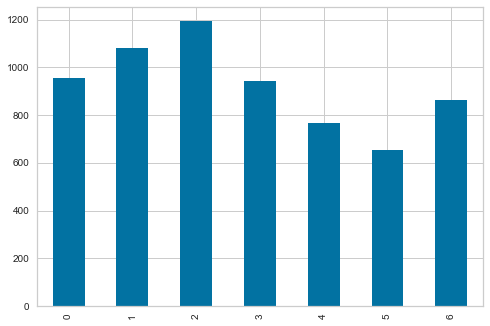

In [4]:
# make day of week column
df['day_of_week']=df[['d','m']].apply(lambda row: dt.datetime.strptime((str(row[0])+str(row[1])+str(2019)),'%d%m%Y').date().weekday(),axis=1)
#plot
df.day_of_week.value_counts().sort_index().plot(kind='bar')

### 0 means Monday. Seems like user volume varies across day of week. 

### Let's break that down week by week!

<AxesSubplot:ylabel='stat_week'>

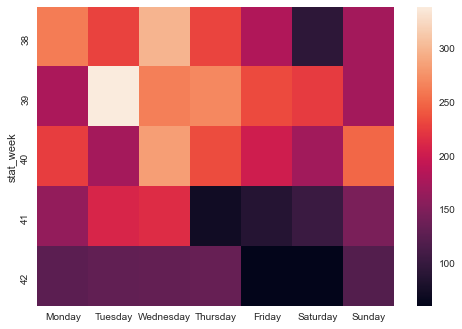

In [5]:
#pivot to get in required crosstab format
week_by_weekday=df.pivot_table(values='user id',index='stat_week',columns='day_of_week',aggfunc='count')
#get mapping from weekday number to weekday name
days = {i:name for i, name in enumerate(calendar.day_name)}
week_by_weekday.columns=days.values()
#plot
sns.heatmap(week_by_weekday)

#### Darker color means lesser signups. <br> Enrollment falls every week. <br>There seems to be lesser enrollment during the end of week, and it picks up on sundays and mondays.

### 3.3 Check overall user response (User funnel)

<AxesSubplot:>

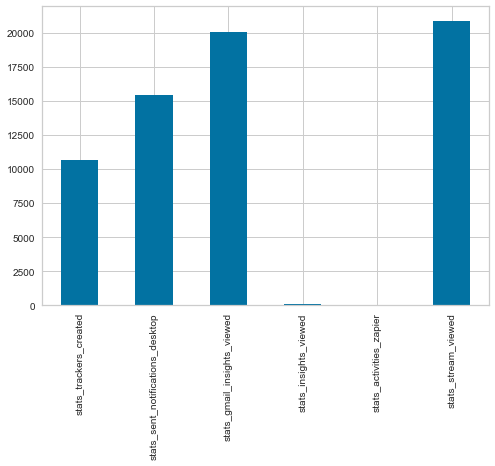

In [6]:
df.sum()[4:-1].plot(kind='bar')

<h4><ul><li> Stream has been viewed the most.</li>
    <li>No one did Zapier integration. Can ignore this field for future analysis.</li>
    <li>There is some kind of flow of users across pages. </li>
    <font color='blue'><li>I assume that when the users come to the landing page, the user flow goes like <i>view gmail insights -> create tracker and wait for notifications -> view insights</i></li>
     <li><i>stream</i> can be viewed at anytime</li></font>
    <li>Based on these assumptions, I believe most users are dropping off after they send mails and receive the notifications, because they do not go to view insights.</li>
    


### 3.4 Is there some correlation between the given metrics?

<AxesSubplot:>

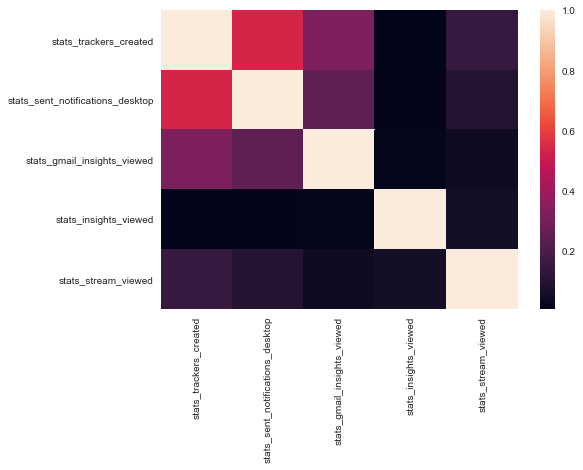

In [7]:
sns.heatmap(df[['stats_trackers_created','stats_sent_notifications_desktop','stats_gmail_insights_viewed','stats_insights_viewed','stats_stream_viewed']].corr())

#### Nothing substantial here :(

### 3.5 Disribution of emails sent

<AxesSubplot:>

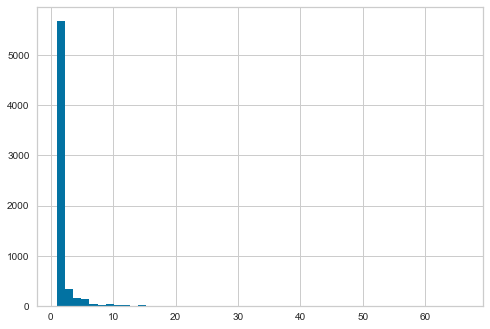

In [8]:
df.stats_trackers_created.hist(bins=50)

#### Most users send only a handful emails, generally less than 10 emails.

### 3.6 Let us see the situation of response received per email.

<AxesSubplot:>

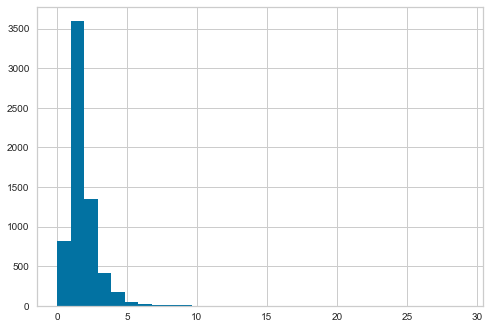

In [9]:
df['notification_per_email']=df.stats_sent_notifications_desktop/df.stats_trackers_created
df.notification_per_email.hist(bins=30)

<h4>Most of the Users who leave, are those who get only 0-5 notifications per email they sent. <br><br><font color='blue'>Assuming that notifications received represent read receipt and response from the sent emails, </font>it can be inferred that the users who receive relatively colder response from their contacts, tend to churn.<h4>

## 4. Clustering Users to identify specific behavior across pages and actions

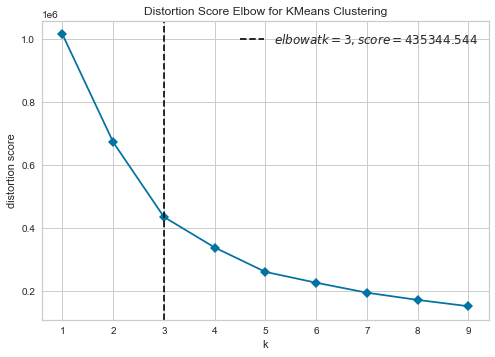

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# take only required metrics
X=df.loc[:,['stats_trackers_created','stats_sent_notifications_desktop','stats_gmail_insights_viewed','stats_insights_viewed','stats_stream_viewed']]
# How many clusters to make?
visualizer = KElbowVisualizer(KMeans(init='k-means++'), k=(1,10),timings=False)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

#### 3 seems to be the optimum cluster number. Let's make 3 clusters and check out their average characteristics!

In [11]:
#k-means algorithm
kmeans = KMeans(n_clusters=3, init='k-means++').fit(X)
#assign each user a cluster
df['Cluster']=kmeans.predict(X)
# see cluster centers
df.groupby('Cluster').agg({'user id':'count',
                           'stats_trackers_created':'mean',
                           'stats_sent_notifications_desktop':'mean',
                           'stats_gmail_insights_viewed':'mean',
                           'stats_insights_viewed':'mean',
                           'stats_stream_viewed':'mean',
                           'notification_per_email':'mean'}).round(2)

,user id,stats_trackers_created,stats_sent_notifications_desktop,stats_gmail_insights_viewed,stats_insights_viewed,stats_stream_viewed,notification_per_email
Cluster,,,,,,,
0,6272,1.51,2.02,1.94,0.01,3.21,1.47
1,181,6.67,15.20,38.02,0.03,4.02,2.17
2,3,2.67,14.33,327.33,0.00,2.33,4.75


#### Looking at the average number of emails sent (trackers created), I perform a statistical test to confirm difference in means.

<h4><font color='blue'> NULL Hypothesis: Metric means of the three clusters are same</font></h4>

In [12]:
# since the populations are small, variances would be high, hence I perform welch's t-test
cat0 = df[df.Cluster==0]    # Cluster 0
cat1 = df[df.Cluster==1]    # Cluster 1
cat2 = df[df.Cluster==2]    # Cluster 2

print('Cluster 0 vs 1\t',ttest_ind(cat0['stats_trackers_created'], cat1['stats_trackers_created'], equal_var=False))
print('Cluster 0 vs 2\t',ttest_ind(cat0['stats_trackers_created'], cat2['stats_trackers_created'], equal_var=False))
print('Cluster 1 vs 2\t',ttest_ind(cat1['stats_trackers_created'], cat2['stats_trackers_created'], equal_var=False))


Cluster 0 vs 1	 Ttest_indResult(statistic=-8.643122278720929, pvalue=2.899093878525231e-15)
Cluster 0 vs 2	 Ttest_indResult(statistic=-1.3108762858355614, pvalue=0.320111971337381)
Cluster 1 vs 2	 Ttest_indResult(statistic=3.7585611001392945, pvalue=0.01782399401277785)


<h4>Looking at p-values, we can say with 95% confidence that Null hypothesis does not fail for the comparison of means of Cluster 0 and 2, while it fails for Cluster 0 vs 1 and Cluster 1 vs 2. <br/><br>In other words, differences in Cluster 0 and 2 are not statistically significant, while for other two combinations, it is significant!</h4>
<h3>For the purpose of this exercise, I ignore these statistical results as the data is small as compared to real world scenario.</h3>

<h2>5. Conclusion</h2>
<h3>Cluster 0</h3>
<ul><li>Close to 97% of the users are in cluster 0. These users sent only 1.5 emails on an average. Assuming that the users are new and take a guided tour of the platform, we know that at least 1 email will be sent during the tour itself. This means that these users generally never sent another email on their own.</li> <li>They probably need a more detailed tour. </li><li>It would be advisable to send them an email or notification if they do not interact with the platform the same day.  </li></ul>


<h3>Cluster 1</h3>
<ul><li>At 2.8% of the population, these users spent more time viewing the contacts from gmail (probably company insights, as provided by HubSpot). </li><li>They sent more emails compared to cluster 0, received more notifications on average and viewed the stream more too.</li><li> These are the customers who were on the verge of becoming a regular customer, but left the platform for some reason.</li></ul>

<h3>Cluster 2</h3>
<ul><li>With just 3 users in the bucket, these customers have very high gmail insight views.</li><li>They came to the platform and did far more research on the contact insights than any other group.</li><li>They received much more notifications per mail as well.</li></ul>

<h3>Summary <br/><ul><li>Customers from Cluster 1 and 2 are the ones who have the potential to be long term customers.</li><li> Personalised marketing campaigns could be run for these, so as to bring them back in the game. </li><li>Considering they are less in number, customer support could reach out to them and assist them. </li></ul></h3>